# MPI for Sonar simulation

## Imports

In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')

In [2]:
%%px --no-stream --group-outputs=engine
%matplotlib inline
from mpi4py import MPI
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("../cli/"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
configuration['mpi'] = True
configuration['language'] = 'openmp'

## Functions and Source

In [19]:
%%px --no-stream --group-outputs=engine

def reconstruct_matrix(vp_data, num_processes):
    if num_processes == 2:
            return np.concatenate([vp_data[0], vp_data[1]], axis=1)
    elif num_processes == 4:
        top_half = np.concatenate([vp_data[0], vp_data[1]], axis=1)
        bottom_half = np.concatenate([vp_data[2], vp_data[3]], axis=1)
        return np.concatenate([top_half, bottom_half], axis=0)
    else:
        raise ValueError("Number of processes not supported")
    
def collect_mpi_data(model, nprocs):
    comm = model.grid.distributor.comm
    rank = model.grid.distributor.myrank
    
        

In [3]:
%%px --no-stream --group-outputs=engine

def plot_velocity(model, vp_data = None, source=None, receiver=None, colorbar=True, cmap="jet"):
    """
    Plot a two-dimensional velocity field from a seismic `Model`
    object. Optionally also includes point markers for sources and receivers.

    Parameters
    ----------
    model : Model
        Object that holds the velocity model.
    source : array_like or float
        Coordinates of the source point.
    receiver : array_like or float
        Coordinates of the receiver points.
    colorbar : bool
        Option to plot the colorbar.
    """
    
    nprocs = model.grid.distributor.nprocs
    if nprocs > 1:
        collect_mpi_data(model, nprocs)

    
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0],
        model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1],
        model.origin[1],
    ]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    nprocs = model.grid.distributor.nprocs
    
    if vp_data is not None:
        field = vp_data[slices]
    else: 
        if getattr(model, "vp", None) is not None:
            field = model.vp.data[slices]
        else:
            field = model.lam.data[slices]
    plot = plt.imshow(
        np.transpose(field),
        animated=True,
        cmap=cmap,
        vmin=np.min(field),
        vmax=np.max(field),
        extent=extent,
    )
    plt.xlabel("X position (m)")
    plt.ylabel("Depth (m)")

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(
            receiver[:, 0], receiver[:, 1], s=25, c="green", marker="D"
        )

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(source[:, 0], source[:, 1], s=25, c="red", marker="o")

    # Ensure axis limits
    plt.xlim(model.origin[0], model.origin[0] + domain_size[0])
    plt.ylim(model.origin[1] + domain_size[1], model.origin[1])

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label("Velocity (km/s)")
    plt.show()

In [3]:
%%px --no-stream --group-outputs=engine

v_env = 1.5
domain_size = (6, 6)
f0 = 5
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20
sonar = Sonar(domain_size, f0, v_env, FlatBottom(), space_order=space_order, dt=dt, spatial_dist=spatial_dist)

[stderr:0] 
Operator `initdamp` ran in 0.01 s
[stderr:1] 
Operator `initdamp` ran in 0.01 s


In [5]:
%%px --no-stream --group-outputs=engine

print(f"Model: {sonar.model.grid.shape}, with extent: {sonar.model.grid.extent}")
print(f"Vp data shape: {sonar.model.vp.data.shape}")

[stdout:0] 
Model: (110, 110), with extent: (10.9, 10.9)
Vp data shape: (55, 55)
[stdout:1] 
Model: (110, 110), with extent: (10.9, 10.9)
Vp data shape: (55, 55)
[stdout:2] 
Model: (110, 110), with extent: (10.9, 10.9)
Vp data shape: (55, 55)
[stdout:3] 
Model: (110, 110), with extent: (10.9, 10.9)
Vp data shape: (55, 55)


In [4]:
%%px --no-stream --group-outputs=engine

ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    "name": "src",
    "grid": sonar.model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonar.time_range,
    "coordinates": src_coord,
}

rec_args = {
    "name": "rec",
    "grid": sonar.model.grid,
    "time_range": sonar.time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
}

sonar.set_source("GaborSource", src_args)
sonar.set_receiver("Receiver", rec_args)
sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

In [ ]:
%%px --no-stream --group-outputs=engine

vp_data = comm.gather(sonar.model.vp.data, root=0)
rec_coords = comm.gather(rec_args["coordinates"], root=0)
src_coords = comm.gather(src_args["coordinates"], root=0)
if rank == 0:
    vp_data = reconstruct_matrix(vp_data, size)
    src_coords = np.concatenate(src_coords, axis=1)
    rec_coords = np.concatenate(rec_coords, axis=1)

[output:0]

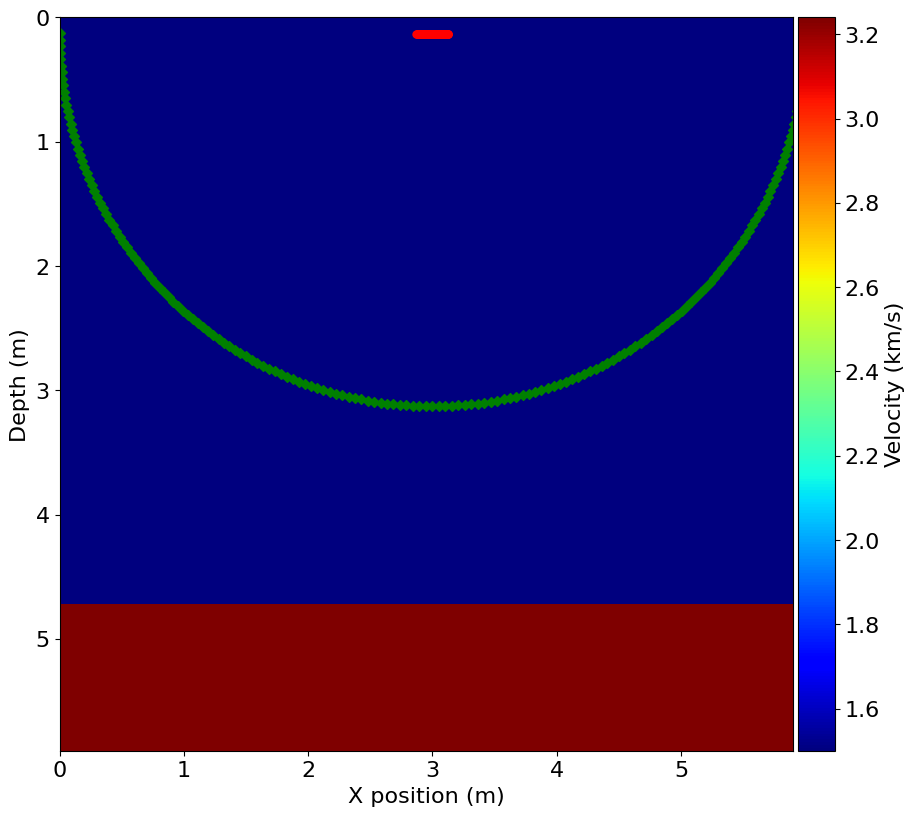

In [22]:
%%px --no-stream --group-outputs=engine

if rank == 0:
    plot_velocity(sonar.model, vp_data=vp_data, source=src_coords, receiver=rec_coords)

## Beamforming

In [3]:
%%px --no-stream --group-outputs=engine

v_env = 1.5
domain_size = (60, 60)
f0 = 50
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Operator `initdamp` generated in 0.41 s
  * lowering.IET: 0.19 s (47.4 %)
     * specializing.IET: 0.14 s (34.9 %)
  * lowering.Clusters: 0.15 s (37.4 %)
     * specializing.Clusters: 0.09 s (22.5 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.14 s from jit-cache
Operator `initdamp` ran in 0.72 s
Global performance: [OI=0.17, 0.11 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,6508> ran in 0.01 s [OI=0.69, 422.87 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,6508> ran in 0.01 s [OI=0.69, 363.67 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section5[rank1]<254> r

In [4]:
%%px --no-stream --group-outputs=engine

ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    a: {
    "name": "src",
    "grid": sonars[a].model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonars[a].time_range,
    "coordinates": src_coord,
    }  
    for a in angles 
}

rec_args = {
    a: {
    "name": "rec",
    "grid": sonars[a].model.grid,
    "time_range": sonars[a].time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
    }
    for a in angles
}

In [5]:
%%px --no-stream --group-outputs=engine

for a, s in sonars.items():
    s.set_source("GaborSource", src_args[a])
    s.set_receiver("Receiver", rec_args[a])
    s.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(188887, 64) [92 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.68 s
  * lowering.Clusters: 0.73 s (43.7 %)
     * specializing.Clusters: 0.44 s (26.3 %)
  * lowering.IET: 0.68 s (40.7 %)
     * specializing.IET: 0.53 s (31.7 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(188887, 64) [92 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.65 s
  * lowering.Clusters: 0.74 s (45.1 %)
     * specializing.Clusters: 0.36 s (22.0 %)
  * lowering.IET: 0.66 s (40.2 %)
     * specializing.IET: 0.52 s (31.7 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(188887, 64) [92 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Ker

In [6]:
%%px --no-stream --group-outputs=engine
print(
    f"The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m"
)
print(f"The time step is {sonars[45].model.critical_dt}")
print(f"fs: {1 / sonars[45].model.critical_dt}")
print(f"Spacing: {sonars[45].model.spacing_map}")
print(f"Time range: {sonars[45].time_range.num}")

[stdout:0] 
The computational grid has (6508, 6508) grid points and physical size of (65.07000000000001, 65.07000000000001) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.010000000000000002}
Time range: 188887
[stdout:1] 
The computational grid has (6508, 6508) grid points and physical size of (65.07000000000001, 65.07000000000001) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.010000000000000002}
Time range: 188887


[output:0]

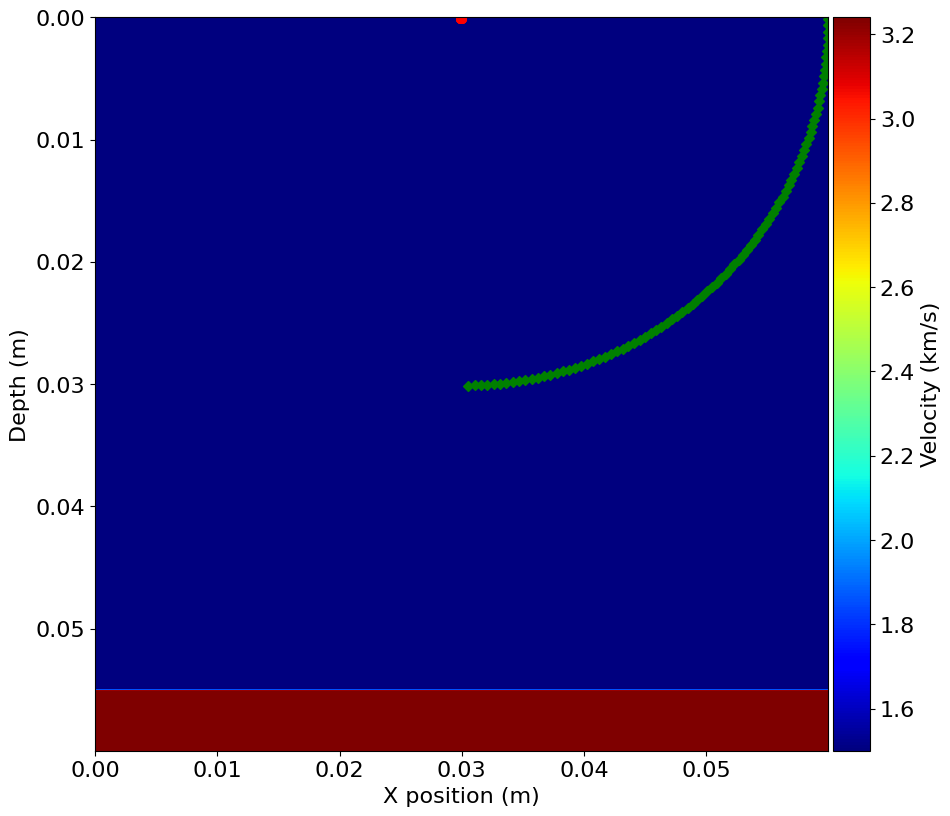

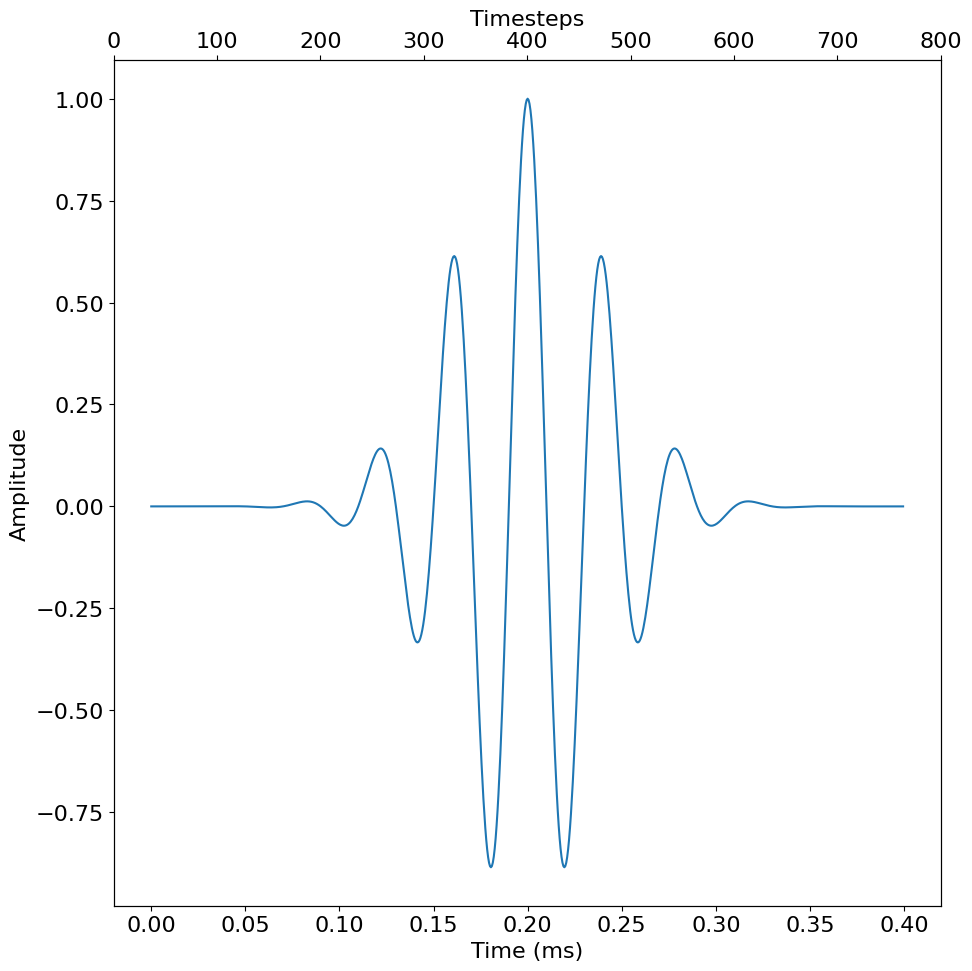

[output:1]

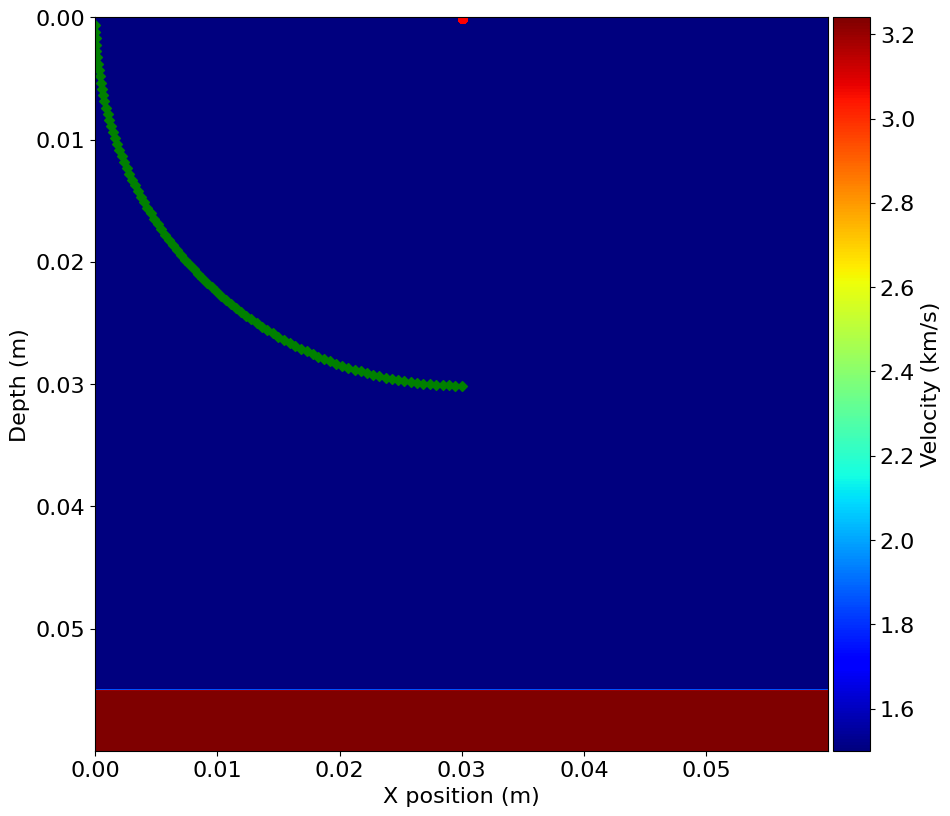

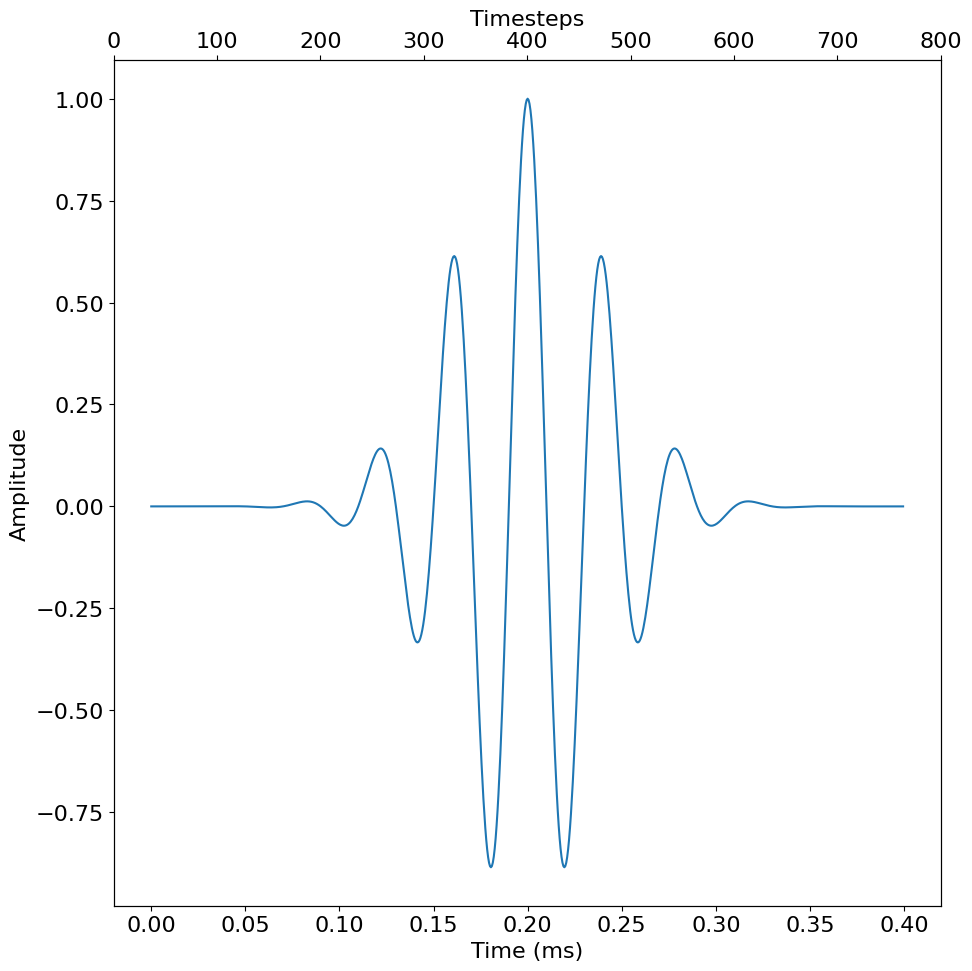

In [7]:
%%px --no-stream --group-outputs=engine

vp_data = comm.gather(sonar.model.vp.data, root=0)
rec_coords = comm.gather(rec_args["coordinates"], root=0)
src_coords = comm.gather(src_args["coordinates"], root=0)
if rank == 0:
    vp_data = reconstruct_matrix(vp_data, size)
    src_coords = np.concatenate(src_coords, axis=1)
    rec_coords = np.concatenate(rec_coords, axis=1)
    
if rank == 0:
    plot_velocity(sonar.model, vp_data=vp_data, source=src_coords, receiver=rec_coords)

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel("Timesteps")
plt.tight_layout()
plt.show()

In [8]:
%%px --no-stream --group-outputs=engine

recordings = {}
for a, s in sonars.items():
    recordings[a] = run_beam(
        s.src,
        s.rec,
        s.op,
        s.u,
        s.source_distance,
        s.time_range,
        s.model.critical_dt,
        a,
        v_env,
    )

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
Simulation took 165.8924241065979 seconds
Simulation took 167.50497031211853 seconds
Simulation took 167.63467502593994 seconds
Simulation took 167.6358768939972 seconds
Simulation took 167.7007339000702 seconds
Simulation took 167.61235070228577 seconds
Simulation took 167.47030758857727 seconds
[stdout:1] 
Simulation took 165.89555430412292 seconds
Simulation took 167.5071575641632 seconds
Simulation took 167.63708186149597 seconds
Simulation took 167.63772535324097 seconds
Simulation took 167.70324611663818 seconds
Simulation took 167.6151647567749 seconds
Simulation took 167.47345972061157 seconds


[stderr:0] 
Allocating host memory for u(3, 3270, 6524) [488 MB]
Allocating host memory for rec(188887, 90) [130 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800157/ded4973e517008aca963617e186bbda64a8d77d7.cpp` in 0.06 s from jit-cache
Operator `Kernel` ran in 164.46 s
Global performance: [OI=1.16, 1799.89 GFlops/s, 48.65 GPts/s]
Local performance:
  * section0[rank0]<89> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<91> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<188885,3254,6508> ran in 159.83 s [OI=1.16, 926.02 GFlops/s, 25.03 GPts/s]
  * section1[rank1]<188885,3254,6508> ran in 159.89 s [OI=1.16, 925.66 GFlops/s, 25.02 GPts/s]
  * section2[rank0]<<188885,64,2,2>,<188885,64,2,2>> ran in 2.16 s [OI=3.00, 1.35 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<188885,69,2,2>,<188885,69,2,2>> ran in 2.16 s [OI=3.00, 1.46 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<188885,89>,<188885,89,2,2>> ran in 2.26 s [OI=0.66, 0.32 GFlops

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

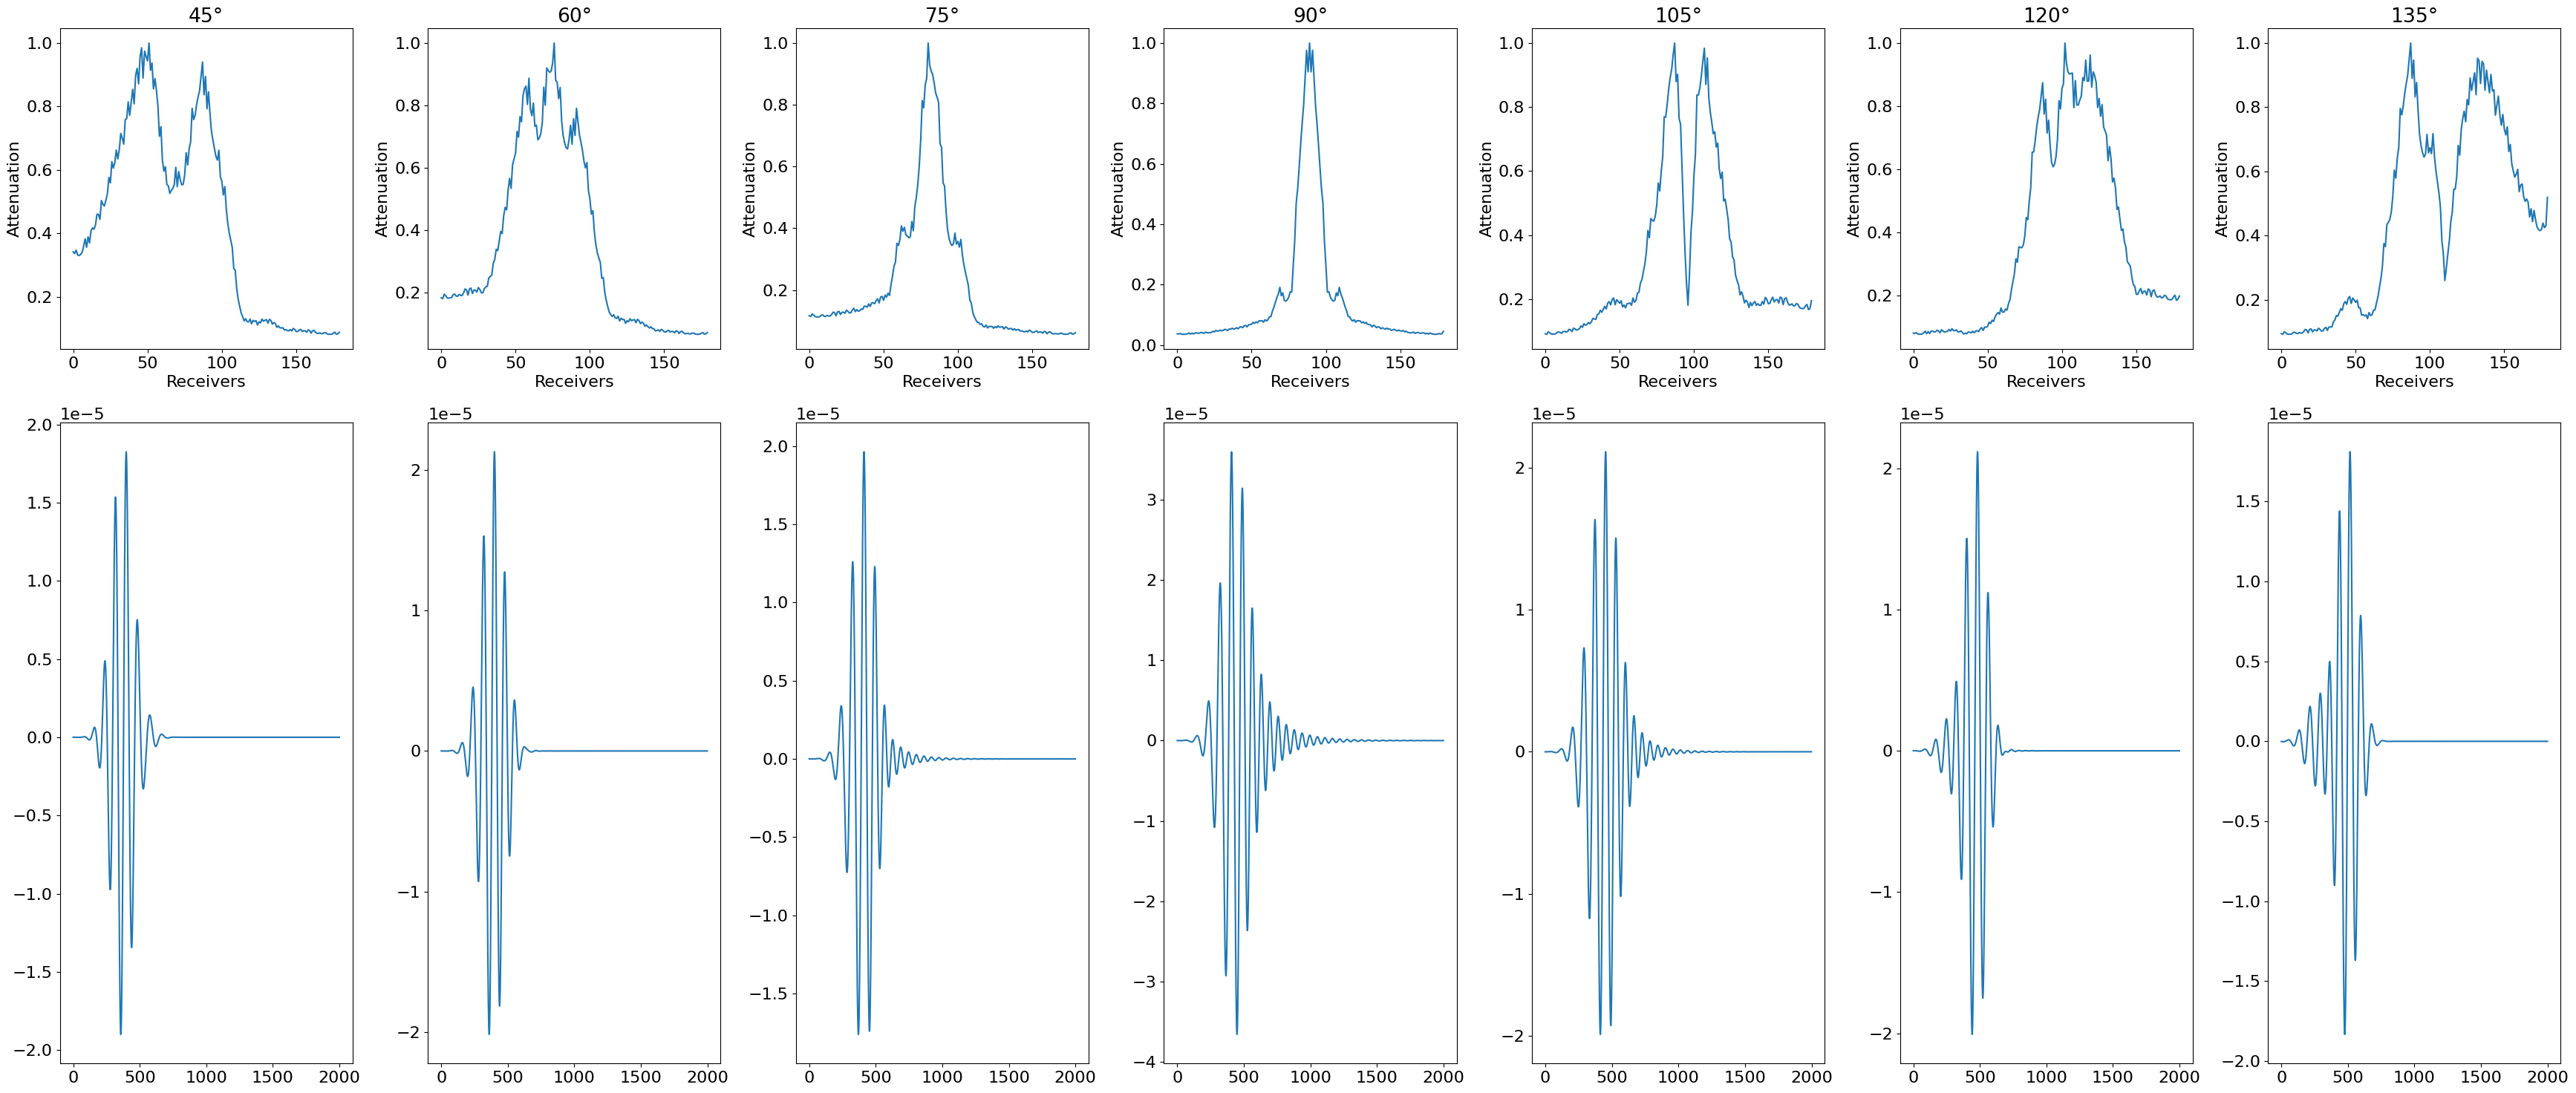

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [13]:
%%px --no-stream --group-outputs=engine

all_recordings = {a: comm.gather(val, root=0) for a, val in recordings.items()}
if rank == 0:
    all_recordings = {a: np.concatenate(val, axis=1) for a, val in all_recordings.items()}
    
    fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
    for i, (a, r) in enumerate(all_recordings.items()):
        recording = np.flip(r)
        ax[0, i].plot(
            np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
        )
        ax[0, i].set_xlabel("Receivers")
        ax[0, i].set_ylabel("Attenuation")
        ax[0, i].set_title(f"{a}°")
        ax[0, i].tick_params()

        ax[1, i].plot(r[40000:42000, 180 - a])
    fig.tight_layout()


## Detection with Correlation

In [3]:
%%px --no-stream --group-outputs=engine

domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20

In [4]:
%%px --no-stream --group-outputs=engine

sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.set_receiver()
sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
51it [00:01, 25.50it/s]
Operator `initdamp` generated in 0.42 s
  * lowering.IET: 0.19 s (45.5 %)
     * specializing.IET: 0.14 s (33.5 %)
  * lowering.Clusters: 0.16 s (38.3 %)
     * specializing.Clusters: 0.10 s (23.9 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.14 s from jit-cache
Operator `initdamp` ran in 2.88 s
Global performance: [OI=0.22, 0.02 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,3508> ran in 0.01 s [OI=0.69, 392.06 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,3508> ran in 0.01 s [OI=0.69, 316.18 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  

In [5]:
%%px --no-stream --group-outputs=engine

recording_45 = run_beam(
    sonar.src,
    sonar.rec,
    sonar.op,
    sonar.u,
    sonar.source_distance,
    sonar.time_range,
    sonar.model.critical_dt,
    45,
    v_env,
)

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
mpicxx -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp -lm -o /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.so
Simulation took 66.77610564231873 seconds
[stdout:1] 
Simulation took 66.77397680282593 seconds


[stderr:0] 
Allocating host memory for u(3, 3270, 3524) [264 MB]
Allocating host memory for rec(123139, 64) [60 MB]
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp` in 2.49 s with `NvidiaCompiler`
Operator `Kernel` ran in 63.47 s
Global performance: [OI=1.28, 1816.06 GFlops/s, 44.30 GPts/s]
Local performance:
  * section0[rank0]<64> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<69> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<123137,3254,3508> ran in 60.66 s [OI=1.28, 950.10 GFlops/s, 23.18 GPts/s]
  * section1[rank1]<123137,3254,3508> ran in 60.71 s [OI=1.28, 949.28 GFlops/s, 23.16 GPts/s]
  * section2[rank0]<<123137,64,2,2>,<123137,64,2,2>> ran in 1.37 s [OI=3.00, 1.40 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<123137,69,2,2>,<123137,69,2,2>> ran in 1.34 s [OI=3.00, 1.53 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<123137,64>,<123137,64,2,2>> ran in 1.34 s [OI=0.66, 0.2